# Training from scratch on Imagewoof with the efficientnet_pytorch repo

https://github.com/lukemelas/EfficientNet-PyTorch

In [1]:
!pip install efficientnet_pytorch

You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
from fastai.script import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.distributed import *
from fastprogress import fastprogress
from torchvision.models import *
from efficientnet_pytorch import EfficientNet
import sys

torch.backends.cudnn.benchmark = True
fastprogress.MAX_COLS = 80

def get_data(size, woof, bs, workers=None):
    if   size<=128: path = URLs.IMAGEWOOF_160 if woof else URLs.IMAGENETTE_160
    elif size<=224: path = URLs.IMAGEWOOF_320 if woof else URLs.IMAGENETTE_320
    else          : path = URLs.IMAGEWOOF     if woof else URLs.IMAGENETTE
    path = untar_data(path)

    n_gpus = num_distrib() or 1
    if workers is None: workers = min(8, num_cpus()//n_gpus)

    return (ImageList.from_folder(path).split_by_folder(valid='val')
            .label_from_folder().transform(([flip_lr(p=0.5)], []), size=size)
            .databunch(bs=bs, num_workers=workers)
            .presize(size, scale=(0.35,1))
            .normalize(imagenet_stats))



Change image size and batch size below depending on model:

In [14]:
data = get_data(300,1,16)   #240, bs=32 for B1, 300, bs=16 for B3

In [15]:
opt_func = partial(optim.Adam, betas=(0.9,0.99), eps=1e-6)

Pick model below:

In [33]:
m = EfficientNet.from_name('efficientnet-b3')

In [34]:
m._fc = nn.Linear(m._fc.in_features, out_features=10, bias=True)
nn.init.kaiming_normal_(m._fc.weight);

In [35]:

learn = (Learner(data, m, wd=1e-5, opt_func=opt_func,
         metrics=[accuracy,top_k_accuracy],
         bn_wd=False, true_wd=True,
         loss_func = LabelSmoothingCrossEntropy())
        )
    

In [36]:
mixup = 0
if mixup: learn = learn.mixup(alpha=mixup)
learn = learn.to_fp16(dynamic=True)
    
        


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


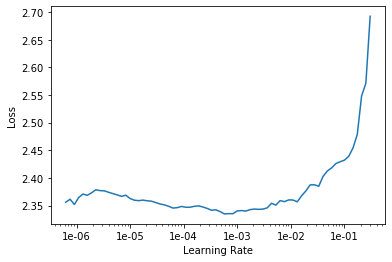

In [10]:
#B1
learn.lr_find()
learn.recorder.plot()

## 5 epochs B1 (xresnet50 gets ~ 62%; xresnet50 + self attention gets 67%)

In [9]:
learn.fit_one_cycle(5, 1e-4, div_factor=10, pct_start=0.3)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.243000,2.305701,0.100000,0.500000,01:57
1,2.116734,2.152997,0.248000,0.742000,01:56
2,2.029070,2.006547,0.310000,0.790000,01:57
3,1.957809,1.923689,0.360000,0.812000,01:56
4,1.930043,1.921397,0.368000,0.794000,01:55


In [15]:
# restarted from scratch
learn.fit_one_cycle(5, 1e-3, div_factor=10, pct_start=0.3)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.115052,2.362708,0.100000,0.500000,01:56
1,1.955134,6.912424,0.176000,0.702000,01:58
2,1.787405,1.831567,0.448000,0.894000,01:56
3,1.657472,1.548386,0.526000,0.936000,01:55
4,1.559327,1.447817,0.578000,0.946000,01:55


In [21]:
# restarted from scratch
learn.fit_one_cycle(5, 5e-3, div_factor=10, pct_start=0.3)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.166082,4.765602,0.100000,0.502000,01:55
1,2.078946,5.777719,0.158000,0.616000,01:54
2,1.976010,3.223228,0.214000,0.688000,01:56
3,1.846923,1.905836,0.310000,0.878000,01:58
4,1.808402,1.717624,0.444000,0.904000,01:56


## 80 epochs B1 (xresnet50 gets 89.9% on 256px)

In [11]:
# restarted from scratch, mixup =0.2
learn.fit_one_cycle(80, 1e-3, div_factor=10, pct_start=0.3)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.184476,2.311704,0.100000,0.500000,01:38
1,2.103570,2.055084,0.322000,0.782000,01:39
2,2.019337,2.018185,0.320000,0.822000,01:39
3,1.976948,2.157684,0.316000,0.826000,01:40
4,1.902679,1.877382,0.396000,0.880000,01:39
5,1.865095,2.133109,0.366000,0.858000,01:40
6,1.807939,1.929397,0.410000,0.876000,01:38
7,1.778791,1.703910,0.474000,0.908000,01:38
8,1.729328,1.739615,0.462000,0.918000,01:38
9,1.700636,1.591024,0.526000,0.934000,01:39


# 5 epochs B3

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


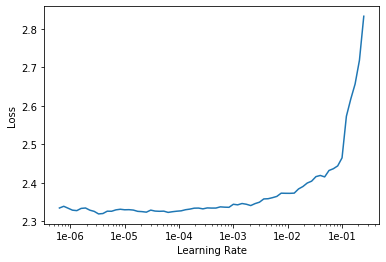

In [20]:
learn.lr_find()
learn.recorder.plot()

In [21]:
learn.fit_one_cycle(5, 1e-4, div_factor=10, pct_start=0.3)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.203645,2.231869,0.182000,0.642000,03:38
1,2.079188,2.154068,0.276000,0.728000,03:39
2,1.915807,1.841970,0.404000,0.848000,03:39
3,1.810711,1.714442,0.450000,0.866000,03:39
4,1.716674,1.668185,0.476000,0.876000,03:37


In [27]:
#restart
learn.fit_one_cycle(5, 1e-3, div_factor=10, pct_start=0.3)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.164451,9.396387,0.154000,0.608000,03:38
1,2.046808,8.089010,0.120000,0.648000,03:38
2,1.949258,1.918408,0.330000,0.874000,03:37
3,1.854580,1.782776,0.396000,0.878000,03:39
4,1.777321,1.711488,0.460000,0.888000,03:38


In [37]:
#restart
learn.fit_one_cycle(5, 5e-5, div_factor=10, pct_start=0.3)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.220925,2.188593,0.202000,0.662000,03:39
1,2.122036,2.170564,0.232000,0.734000,03:39
2,2.037724,2.030975,0.284000,0.796000,03:39
3,1.939514,1.934067,0.356000,0.808000,03:39
4,1.904811,1.904735,0.366000,0.820000,03:38
